In [1]:
!pip install fastai2 --quiet

     |████████████████████████████████| 194kB 2.8MB/s 


## Transform

In [0]:
from fastai2.vision.all import *

In [3]:
source = untar_data(URLs.PETS)/"images"
items = get_image_files(source)

In [0]:
def resized_image(fn:Path, sz=128): #python typecasting to take only pathlib paths as input to function
    x = Image.open(fn).convert('RGB').resize((sz,sz))
    # Convert image to tensor for modeling
    return tensor(array(x)).permute(2,0,1).float()/255.
    # ?? What does `.permute(2, 0, 1) do?` 

In [0]:
# Before we can create a Transform, we need a type that knows how to show itself (if we want to use the show method). 
# Here we define a TitledImage
class TitledImage(Tuple):
    def show(self, ctx=None, **kwargs): show_titled_image(self, ctx=ctx, **kwargs)

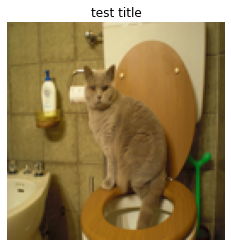

In [6]:
img = resized_image(items[0])
TitledImage(img,'test title').show()

In [0]:
class PetTfm(Transform):
    def __init__(self, vocab, o2i, lblr): self.vocab,self.o2i,self.lblr = vocab,o2i,lblr
    def encodes(self, o): return [resized_image(o), self.o2i[self.lblr(o)]]
    def decodes(self, x): return TitledImage(x[0],self.vocab[x[1]])

labeller = using_attr(RegexLabeller(pat = r'^(.*)_\d+.jpg$'), 'name')
vals = list(map(labeller, items))
vocab,o2i = uniqueify(vals, sort=True, bidir=True) #function that gives a unique dictyionary of keys and values

In [0]:
pets = PetTfm(vocab,o2i,labeller)

In [9]:
x,y = pets(items[0])
x.shape,y

(torch.Size([3, 128, 128]), 4)

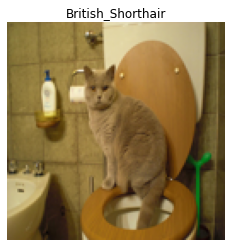

In [10]:
dec = pets.decode([x,y])
dec.show()

In [0]:
## Calling the setup stuff by utilizing the setups method
class PetTfm(ItemTransform):
    def setups(self, items):
        self.labeller = using_attr(RegexLabeller(pat = r'^(.*)_\d+.jpg$'), 'name')
        vals = map(self.labeller, items)
        self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True)

    def encodes(self, o): return (resized_image(o), self.o2i[self.labeller(o)])
    def decodes(self, x): return TitledImage(x[0],self.vocab[x[1]])

In [0]:
pets = PetTfm()
pets.setup(items) # setup labeller, 02i and vocab using the setups method

In [13]:
x,y = pets(items[0])
x.shape, y

(torch.Size([3, 128, 128]), 4)

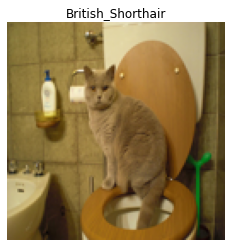

In [14]:
dec = pets.decode((x,y))
dec.show()

## Pipeline

We can take advantage of fastai's data augmentation transforms if we give the right type to our elements. Instead of returning a standard PIL.Image, if our transform returns the fastai type PILImage, we can then use any fastai's transform with it. Let's just return a PILImage for our first element:

In [0]:
Resize??

In [0]:
class PetTfm(ItemTransform):
    def setups(self, items):
        self.labeller = using_attr(RegexLabeller(pat = r'^(.*)_\d+.jpg$'), 'name')
        vals = map(self.labeller, items)
        self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True)

    def encodes(self, o): return (PILImage.create(o), self.o2i[self.labeller(o)])
    def decodes(self, x): return TitledImage(x[0],self.vocab[x[1]])

We can then combine that transform with ToTensor, Resize or FlipItem to randomly flip our image in a Pipeline:

In [17]:
items

(#7390) [Path('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_151.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_151.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_71.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_169.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/chihuahua_93.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_25.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_25.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/leonberger_106.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pomeranian_188.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pug_26.jpg')...]

In [0]:
tfms = Pipeline([PetTfm(), Resize(224), FlipItem(p=1), ToTensor()])

In [0]:
# Calling setup on a Pipeline will set each transform in order:
tfms.setup(items)

In [20]:
tfms

Pipeline: PetTfm -> FlipItem -> Resize -> ToTensor

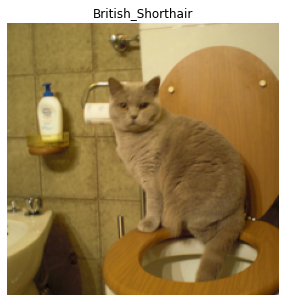

In [21]:
tfms.show(tfms(items[0]))

## TfmdLists and Datasets

The main difference between TfmdLists and Datasets is the number of Pipelines you have: TfmdLists take one Pipeline to transform a list (like we currently have) whereas Datasets combines several Pipelines in parallel to create a tuple from one set of raw items, for instance a tuple (input, target).

### Tfmdlists

In [22]:
# One pipeline makes a TfmdLists
tls = TfmdLists(items, [Resize(224), PetTfm(), FlipItem(p=0.5), ToTensor()])
x,y = tls[0]
x.shape,y

(torch.Size([3, 224, 224]), 4)

In [23]:
tls.vocab

(#37) ['Abyssinian','Bengal','Birman','Bombay','British_Shorthair','Egyptian_Mau','Maine_Coon','Persian','Ragdoll','Russian_Blue'...]

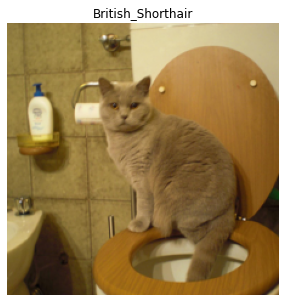

In [24]:
tls.show(tls[0])

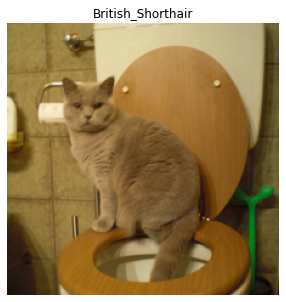

In [25]:
show_at(tls, 0)

TfmdLists has an 's' in its name because it can represent several transformed lists: your training and validation sets. To use that functionality, we just need to pass splits to the initialization. splits should be a list of lists of indices (one list per set). To help create splits, we can use all the splitters of the fastai library:

In [26]:
splits = RandomSplitter(seed=42)(items)
splits

((#5912) [5643,5317,5806,3460,613,5456,2968,3741,10,4908...],
 (#1478) [4512,4290,5770,706,2200,4320,6450,501,1290,6435...])

In [0]:
tls = TfmdLists(items, [Resize(224), PetTfm(), FlipItem(p=0.5), ToTensor()], splits=splits)

In [28]:
len(tls.valid), len(tls.train)

(1478, 5912)

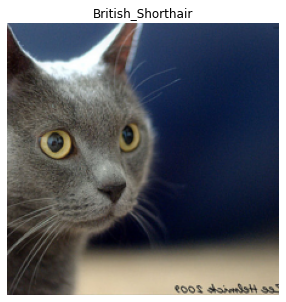

In [29]:
show_at(tls.train, 0)

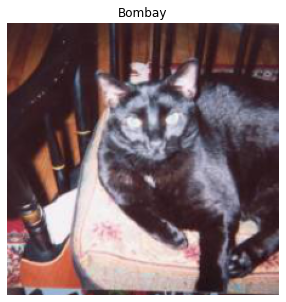

In [30]:
show_at(tls.valid, 0)

In [31]:
len(tls.train.vocab), len(tls.valid.vocab)

(37, 37)

From a TfmdLists, getting a DataLoaders object is very easy, you just have to call the dataloaders method:

In [0]:
dls = tls.dataloaders() # default bs=64

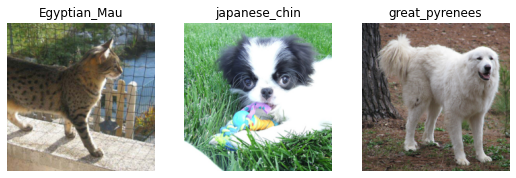

In [33]:
dls.show_batch(max_n=3)

You can even add augmentation transforms, since we have a proper fastai typed image. Just remember to add the IntToFloatTensor transform that deals with the conversion of int to float (augmentation transforms of fastai on the GPU require float tensors). When calling TfmdLists.dataloaders, you pass the batch_tfms to after_batch (and potential new item_tfms to after_item):

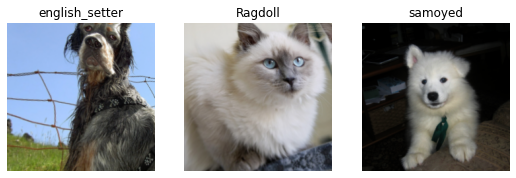

In [34]:
dls = tls.dataloaders(bs=64, after_batch=[IntToFloatTensor(), *aug_transforms()])
dls.show_batch(max_n=3)

### Datasets

In [0]:
class ImageResizer(Transform):
    order=1
    "Resize image to `size` using `resample`"
    def __init__(self, size, resample=Image.BILINEAR):
        if not is_listy(size): size=(size,size)
        self.size,self.resample = (size[1],size[0]),resample

    def encodes(self, o:PILImage): return o.resize(size=self.size, resample=self.resample) # type-annotatiosn such that this transform encodes only items which are either of type 'PILImage'
    def encodes(self, o:PILMask):  return o.resize(size=self.size, resample=Image.NEAREST) # or 'PILMask'

In [0]:
tfms = [[PILImage.create, ImageResizer(128), ToTensor(), IntToFloatTensor()],
        [labeller, Categorize()]]
dsets = Datasets(items, tfms, splits=splits) # datasets take in multiple set of transforms; here 1st is for images to get x's and second is to get labels y's. 

In [37]:
t = dsets[0]
type(t[0]),type(t[1])

(fastai2.torch_core.TensorImage, fastai2.torch_core.TensorCategory)

In [38]:
x,y = dsets.decode(t)
x.shape,y

(torch.Size([3, 128, 128]), 'British_Shorthair')

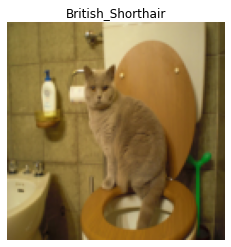

In [39]:
dsets.show(t)

But we are not using the fact that `Transform`s dispatch over tuples here. `ImageResizer`, `ToTensor` and `IntToFloatTensor` could be passed as transforms over the tuple. This is done in `.dataloaders` by passing them to `after_item`. They won't do anything to the category but will only be applied to the inputs.

In [0]:
tfms = [[PILImage.create], [labeller, Categorize()]]
dsets = Datasets(items, tfms, splits=splits)
dls = dsets.dataloaders(bs=64, after_item=[ImageResizer(128), ToTensor(), IntToFloatTensor()])

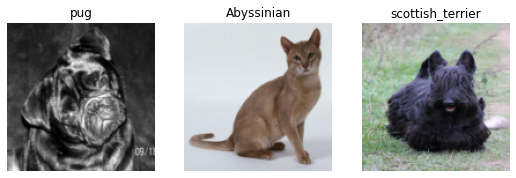

In [41]:
dls.show_batch(max_n=3)